1/1 [==============================] - 0s 168ms/step
Hybrid Model Evaluation (Normali):
RMSE: 11.9425
MSE: 142.6234
MAE: 10.2367
R2 Score: 0.0645
Accuracy: 90.88%


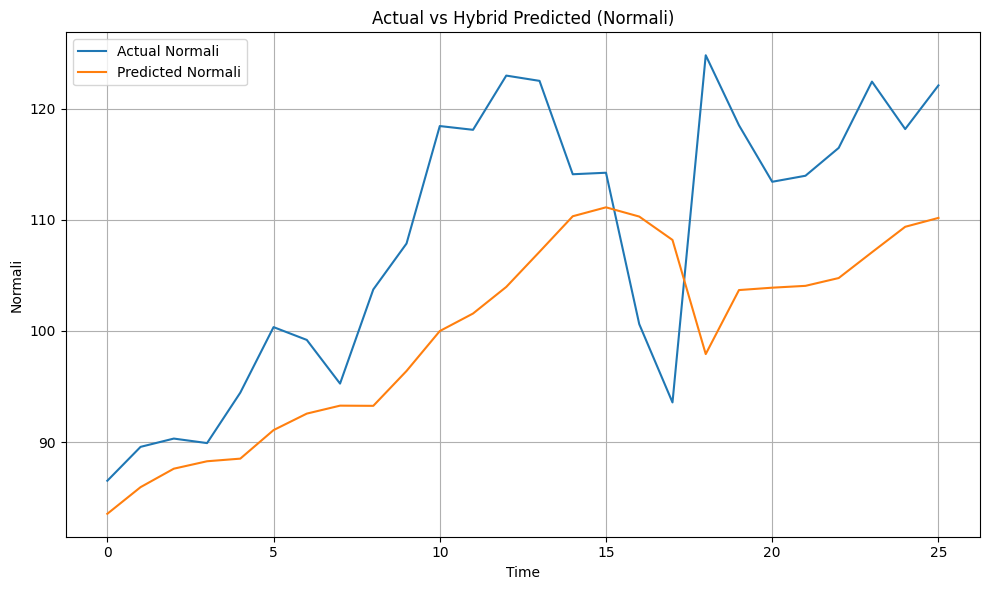


Future 4 Weeks Hybrid Normali Predictions:
2023-01-15: 110.59
2023-01-22: 109.56
2023-01-29: 108.26
2023-02-05: 106.90


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

import xgboost as xgb

# Load Dataset
df = pd.read_csv('cb_new_1.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Calculate Normali Column 
first_value = df['CB_n330_Avg'].iloc[0]
df['Normali'] = (df['CB_n330_Avg'] / first_value) * 100

# Prepare Data 
data = df[['Normali']].dropna()

# Feature Scaling 
scaler_y = MinMaxScaler()
data_scaled = scaler_y.fit_transform(data)

# Create Sequences 
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(data_scaled, seq_length)

# Train-Test Split 
train_size = int(len(X) * 0.8)
X_train_lstm, X_test_lstm = X[:train_size], X[train_size:]
y_train_lstm, y_test_lstm = y[:train_size], y[train_size:]

# LSTM Model 
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_lstm, y_train_lstm,
                    epochs=100,
                    batch_size=16,
                    validation_data=(X_test_lstm, y_test_lstm),
                    callbacks=[early_stop],
                    verbose=0)

# LSTM Predictions 
predictions = model.predict(X_test_lstm)
predictions_rescaled = scaler_y.inverse_transform(predictions).flatten()
y_test_rescaled = scaler_y.inverse_transform(y_test_lstm).flatten()

# XGBoost Data Preparation 
X_xgb = []
for i in range(len(data_scaled) - seq_length):
    X_xgb.append(data_scaled[i:i + seq_length].flatten())
X_xgb = np.array(X_xgb)

X_train_xgb = X_xgb[:train_size]
X_test_xgb = X_xgb[train_size:]
y_train_xgb = y[:train_size].flatten()
y_test_xgb = y[train_size:].flatten()

# XGBoost Model 
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train_xgb, y_train_xgb)

# XGBoost Predictions 
y_pred_xgb = xgb_model.predict(X_test_xgb)
y_pred_xgb_rescaled = scaler_y.inverse_transform(y_pred_xgb.reshape(-1, 1)).flatten()

# Hybrid Model 
min_len = min(len(predictions_rescaled), len(y_pred_xgb_rescaled))
predictions_lstm = predictions_rescaled[:min_len]
y_pred_xgb_trimmed = y_pred_xgb_rescaled[:min_len]
y_test_combined = y_test_rescaled[:min_len].flatten()

hybrid_test_pred = (predictions_lstm + y_pred_xgb_trimmed) / 2

# Evaluation
hybrid_rmse = sqrt(mean_squared_error(y_test_combined, hybrid_test_pred))
hybrid_mse = mean_squared_error(y_test_combined, hybrid_test_pred)
hybrid_mae = mean_absolute_error(y_test_combined, hybrid_test_pred)
hybrid_r2 = r2_score(y_test_combined, hybrid_test_pred)
hybrid_accuracy = 100 - np.mean(np.abs((y_test_combined - hybrid_test_pred) / y_test_combined)) * 100

print(f'Hybrid Model Evaluation (Normali):')
print(f'RMSE: {hybrid_rmse:.4f}')
print(f'MSE: {hybrid_mse:.4f}')
print(f'MAE: {hybrid_mae:.4f}')
print(f'R2 Score: {hybrid_r2:.4f}')
print(f'Accuracy: {hybrid_accuracy:.2f}%')

# Plot Actual vs Predicted 
plt.figure(figsize=(10, 6))
plt.plot(y_test_combined, label='Actual Normali')
plt.plot(hybrid_test_pred, label='Predicted Normali')
plt.title('Actual vs Hybrid Predicted (Normali)')
plt.xlabel('Time')
plt.ylabel('Normali')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Future Prediction (Next 4 Weeks in Normali)
last_sequence = data_scaled[-seq_length:]
future_predictions = []

last_date = data.index[-1]

for i in range(4):  # 4 weeks ahead
    lstm_input = last_sequence.reshape(1, seq_length, 1)
    lstm_pred = model.predict(lstm_input, verbose=0)[0][0]

    xgb_input = last_sequence.flatten().reshape(1, -1)
    xgb_pred = xgb_model.predict(xgb_input)[0]

    hybrid_pred = (lstm_pred + xgb_pred) / 2
    future_predictions.append(hybrid_pred)

    # Append and slide
    last_sequence = np.append(last_sequence, [[hybrid_pred]], axis=0)[1:]

# Inverse transform Normali
future_predictions_rescaled = scaler_y.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

# Print Future Normali Predictions 
print("\nFuture 4 Weeks Hybrid Normali Predictions:")
for i, val in enumerate(future_predictions_rescaled, 1):
    date = (last_date + pd.DateOffset(weeks=i)).strftime('%Y-%m-%d')
    print(f"{date}: {val:.2f}")


1/1 [==============================] - 0s 172ms/step
Hybrid Model Evaluation (Normali):
RMSE: 11.5169
MSE: 132.6388
MAE: 9.8590
R2 Score: 0.0999
Accuracy: 91.38%


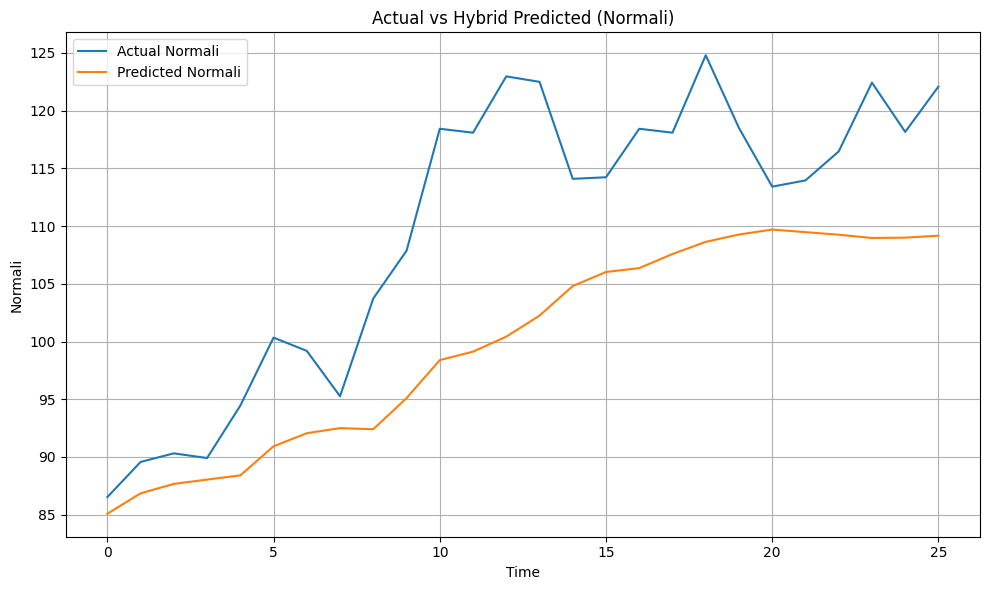


Future 4 Weeks Hybrid Normali Predictions:
2023-01-15: 109.50
2023-01-22: 109.10
2023-01-29: 108.67
2023-02-05: 107.97


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

import xgboost as xgb

# Load Dataset 
df = pd.read_csv('cb_new_3.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Calculate Normali Column 
first_value = df['CB_n330_Avg'].iloc[0]
df['Normali'] = (df['CB_n330_Avg'] / first_value) * 100

# Prepare Data 
data = df[['Normali']].dropna()

# Feature Scaling 
scaler_y = MinMaxScaler()
data_scaled = scaler_y.fit_transform(data)

# Create Sequences 
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(data_scaled, seq_length)

# Train-Test Split 
train_size = int(len(X) * 0.8)
X_train_lstm, X_test_lstm = X[:train_size], X[train_size:]
y_train_lstm, y_test_lstm = y[:train_size], y[train_size:]

# LSTM Model 
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_lstm, y_train_lstm,
                    epochs=100,
                    batch_size=16,
                    validation_data=(X_test_lstm, y_test_lstm),
                    callbacks=[early_stop],
                    verbose=0)

# LSTM Predictions 
predictions = model.predict(X_test_lstm)
predictions_rescaled = scaler_y.inverse_transform(predictions).flatten()
y_test_rescaled = scaler_y.inverse_transform(y_test_lstm).flatten()

#  XGBoost Data Preparation 
X_xgb = []
for i in range(len(data_scaled) - seq_length):
    X_xgb.append(data_scaled[i:i + seq_length].flatten())
X_xgb = np.array(X_xgb)

X_train_xgb = X_xgb[:train_size]
X_test_xgb = X_xgb[train_size:]
y_train_xgb = y[:train_size].flatten()
y_test_xgb = y[train_size:].flatten()

#  XGBoost Model 
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train_xgb, y_train_xgb)

#  XGBoost Predictions 
y_pred_xgb = xgb_model.predict(X_test_xgb)
y_pred_xgb_rescaled = scaler_y.inverse_transform(y_pred_xgb.reshape(-1, 1)).flatten()

#  Hybrid Model 
min_len = min(len(predictions_rescaled), len(y_pred_xgb_rescaled))
predictions_lstm = predictions_rescaled[:min_len]
y_pred_xgb_trimmed = y_pred_xgb_rescaled[:min_len]
y_test_combined = y_test_rescaled[:min_len].flatten()

hybrid_test_pred = (predictions_lstm + y_pred_xgb_trimmed) / 2

#  Evaluation 
hybrid_rmse = sqrt(mean_squared_error(y_test_combined, hybrid_test_pred))
hybrid_mse = mean_squared_error(y_test_combined, hybrid_test_pred)
hybrid_mae = mean_absolute_error(y_test_combined, hybrid_test_pred)
hybrid_r2 = r2_score(y_test_combined, hybrid_test_pred)
hybrid_accuracy = 100 - np.mean(np.abs((y_test_combined - hybrid_test_pred) / y_test_combined)) * 100

print(f'Hybrid Model Evaluation (Normali):')
print(f'RMSE: {hybrid_rmse:.4f}')
print(f'MSE: {hybrid_mse:.4f}')
print(f'MAE: {hybrid_mae:.4f}')
print(f'R2 Score: {hybrid_r2:.4f}')
print(f'Accuracy: {hybrid_accuracy:.2f}%')

#  Plot Actual vs Predicted 
plt.figure(figsize=(10, 6))
plt.plot(y_test_combined, label='Actual Normali')
plt.plot(hybrid_test_pred, label='Predicted Normali')
plt.title('Actual vs Hybrid Predicted (Normali)')
plt.xlabel('Time')
plt.ylabel('Normali')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  Future Prediction (Next 4 Weeks in Normali) 
last_sequence = data_scaled[-seq_length:]
future_predictions = []

last_date = data.index[-1]

for i in range(4):  # 4 weeks ahead
    lstm_input = last_sequence.reshape(1, seq_length, 1)
    lstm_pred = model.predict(lstm_input, verbose=0)[0][0]

    xgb_input = last_sequence.flatten().reshape(1, -1)
    xgb_pred = xgb_model.predict(xgb_input)[0]

    hybrid_pred = (lstm_pred + xgb_pred) / 2
    future_predictions.append(hybrid_pred)

    # Append and slide
    last_sequence = np.append(last_sequence, [[hybrid_pred]], axis=0)[1:]

# Inverse transform Normali
future_predictions_rescaled = scaler_y.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

#  Print Future Normali Predictions 
print("\nFuture 4 Weeks Hybrid Normali Predictions:")
for i, val in enumerate(future_predictions_rescaled, 1):
    date = (last_date + pd.DateOffset(weeks=i)).strftime('%Y-%m-%d')
    print(f"{date}: {val:.2f}")


### GRU

Epoch 1/70
7/7 [==============================] - 2s 83ms/step - loss: 0.2218 - mae: 0.4228 - val_loss: 0.3738 - val_mae: 0.5998
Epoch 2/70
7/7 [==============================] - 0s 10ms/step - loss: 0.0668 - mae: 0.2178 - val_loss: 0.1118 - val_mae: 0.3230
Epoch 3/70
7/7 [==============================] - 0s 12ms/step - loss: 0.0116 - mae: 0.0895 - val_loss: 0.0113 - val_mae: 0.0888
Epoch 4/70
7/7 [==============================] - 0s 12ms/step - loss: 0.0139 - mae: 0.0939 - val_loss: 0.0071 - val_mae: 0.0684
Epoch 5/70
7/7 [==============================] - 0s 12ms/step - loss: 0.0089 - mae: 0.0749 - val_loss: 0.0244 - val_mae: 0.1349
Epoch 6/70
7/7 [==============================] - 0s 10ms/step - loss: 0.0081 - mae: 0.0752 - val_loss: 0.0348 - val_mae: 0.1677
Epoch 7/70
7/7 [==============================] - 0s 12ms/step - loss: 0.0071 - mae: 0.0699 - val_loss: 0.0209 - val_mae: 0.1241
Epoch 8/70
7/7 [==============================] - 0s 13ms/step - loss: 0.0056 - mae: 0.0607 - val

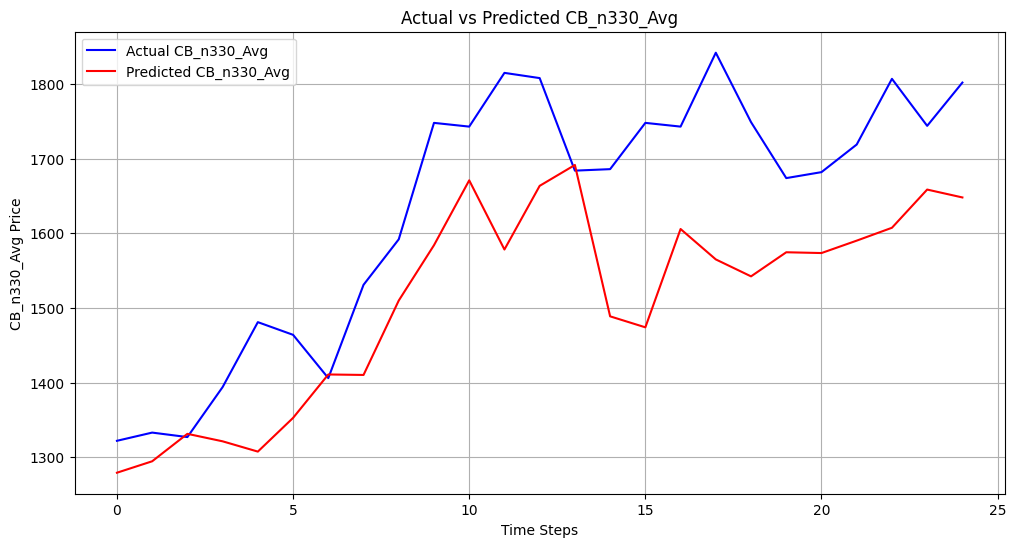

1/1 [==============================] - 0s 22ms/step

Future 3 Months CB_n330_Avg Predictions:
        Date  Predicted CB_n330_Avg
0 2023-02-08            1648.081665
1 2023-03-08            1619.657959
2 2023-04-08            1607.444214


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('cb_new_3.csv')  

# Drop missing values
data.dropna(inplace=True)

# Sort by date
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Define features and target
features = ['Price', 'Open', 'High', 'Low', 'Vol', 'CB_n330_Low', 'CB_n330_High', 'BCO_Close', 'EMA_3']
target = 'CB_n330_Avg'

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features + [target]])
scaled_df = pd.DataFrame(scaled_data, columns=features + [target])

# Sequence generator
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, :-1])  # all features
        y.append(data[i+time_steps, -1])     # target
    return np.array(X), np.array(y)

time_steps = 12
X, y = create_sequences(scaled_df.values, time_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)

# Build GRU model
model = Sequential([
    GRU(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=70, batch_size=16,
                    validation_data=(X_test, y_test), verbose=1)

# Evaluate
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {loss}")
print(f"Test MAE: {mae}")

# Reverse scale the predictions
scaler_target = MinMaxScaler()
scaler_target.fit(data[[target]])
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))
predictions = model.predict(X_test)
predictions_rescaled = scaler_target.inverse_transform(predictions)

# Accuracy metrics
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
mape = np.mean(np.abs((y_test_rescaled - predictions_rescaled) / y_test_rescaled)) * 100
accuracy = 100 - mape

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual CB_n330_Avg', color='blue')
plt.plot(predictions_rescaled, label='Predicted CB_n330_Avg', color='red')
plt.title('Actual vs Predicted CB_n330_Avg')
plt.xlabel('Time Steps')
plt.ylabel('CB_n330_Avg Price')
plt.legend()
plt.grid(True)
plt.show()

# Future prediction (next 3 months)
future_steps = 3
last_sequence = X_test[-1]
future_preds = []

for _ in range(future_steps):
    pred = model.predict(last_sequence[np.newaxis, :, :])[0, 0]
    future_preds.append(pred)
    new_seq = np.append(last_sequence[1:], [np.append(last_sequence[-1, :-1], pred)], axis=0)
    last_sequence = new_seq

future_preds_rescaled = scaler_target.inverse_transform(np.array(future_preds).reshape(-1, 1))

# Generate future dates
last_date = data['Date'].iloc[-1]
future_dates = [last_date + pd.DateOffset(months=i+1) for i in range(future_steps)]

# Display future predictions
future_df = pd.DataFrame({'Date': future_dates, 'Predicted CB_n330_Avg': future_preds_rescaled.flatten()})
print("\nFuture 3 Months CB_n330_Avg Predictions:")
print(future_df)


### GRU With early Stopping 

Epoch 1/100
7/7 [==============================] - 2s 45ms/step - loss: 0.1445 - mae: 0.3386 - val_loss: 0.2609 - val_mae: 0.4966
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0303 - mae: 0.1433 - val_loss: 0.0300 - val_mae: 0.1383
Epoch 3/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0135 - mae: 0.0934 - val_loss: 0.0127 - val_mae: 0.0812
Epoch 4/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0115 - mae: 0.0880 - val_loss: 0.0314 - val_mae: 0.1463
Epoch 5/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0071 - mae: 0.0699 - val_loss: 0.0408 - val_mae: 0.1775
Epoch 6/100
7/7 [==============================] - 0s 13ms/step - loss: 0.0065 - mae: 0.0660 - val_loss: 0.0292 - val_mae: 0.1430
Epoch 7/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0054 - mae: 0.0580 - val_loss: 0.0251 - val_mae: 0.1314
Epoch 8/100
7/7 [==============================] - 0s 12ms/step - loss: 0.0050 - mae: 0.05

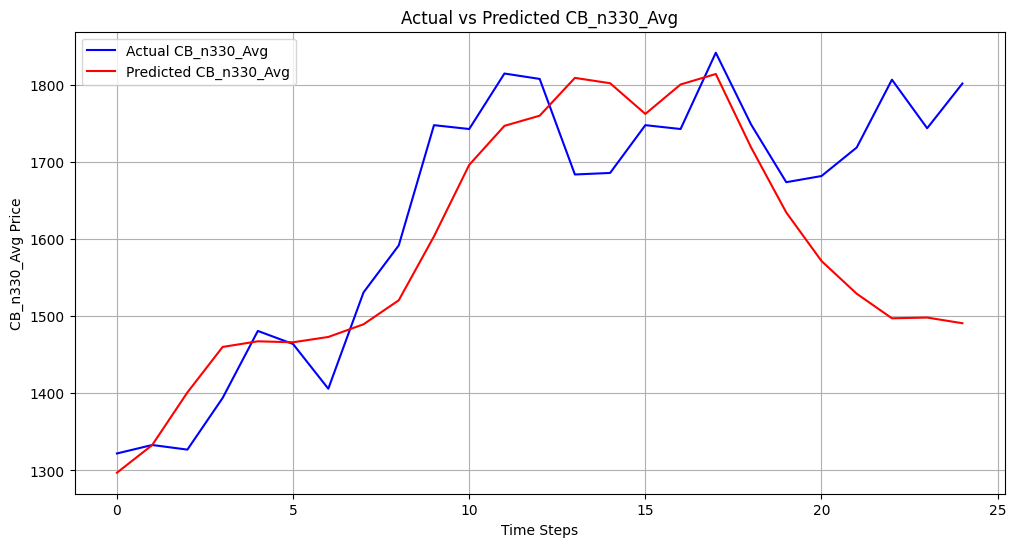

1/1 [==============================] - 0s 28ms/step

Future 3 Months CB_n330_Avg Predictions:
        Date  Predicted CB_n330_Avg
0 2023-02-08            1490.999390
1 2023-03-08            1483.220337
2 2023-04-08            1474.796143


In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('cb_new_3.csv')
data.dropna(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Define features and target
features = ['Price', 'Open', 'High', 'Low', 'Vol', 'CB_n330_Low', 'CB_n330_High', 'BCO_Close', 'EMA_3']
target = 'CB_n330_Avg'

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features + [target]])
scaled_df = pd.DataFrame(scaled_data, columns=features + [target])

# Sequence generator
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, :-1])
        y.append(data[i+time_steps, -1])
    return np.array(X), np.array(y)

time_steps = 12
X, y = create_sequences(scaled_df.values, time_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build GRU model
model = Sequential([
    GRU(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=16,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop],
                    verbose=1)

# Evaluate
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {loss}")
print(f"Test MAE: {mae}")

# Reverse scale the predictions
scaler_target = MinMaxScaler()
scaler_target.fit(data[[target]])
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))
predictions = model.predict(X_test)
predictions_rescaled = scaler_target.inverse_transform(predictions)

# Accuracy metrics
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
mape = np.mean(np.abs((y_test_rescaled - predictions_rescaled) / y_test_rescaled)) * 100
accuracy = 100 - mape

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual CB_n330_Avg', color='blue')
plt.plot(predictions_rescaled, label='Predicted CB_n330_Avg', color='red')
plt.title('Actual vs Predicted CB_n330_Avg')
plt.xlabel('Time Steps')
plt.ylabel('CB_n330_Avg Price')
plt.legend()
plt.grid(True)
plt.show()

# Future prediction (next 3 months)
future_steps = 3
last_sequence = X_test[-1]
future_preds = []

for _ in range(future_steps):
    pred = model.predict(last_sequence[np.newaxis, :, :])[0, 0]
    future_preds.append(pred)
    new_seq = np.append(last_sequence[1:], [np.append(last_sequence[-1, :-1], pred)], axis=0)
    last_sequence = new_seq

future_preds_rescaled = scaler_target.inverse_transform(np.array(future_preds).reshape(-1, 1))

# Generate future dates
last_date = data['Date'].iloc[-1]
future_dates = [last_date + pd.DateOffset(months=i+1) for i in range(future_steps)]

# Display future predictions
future_df = pd.DataFrame({'Date': future_dates, 'Predicted CB_n330_Avg': future_preds_rescaled.flatten()})
print("\nFuture 3 Months CB_n330_Avg Predictions:")
print(future_df)


### GRU + XGBoost

Epoch 1/80
7/7 [==============================] - 5s 82ms/step - loss: 0.0450 - mae: 0.1685 - val_loss: 0.0172 - val_mae: 0.1081
Epoch 2/80
7/7 [==============================] - 0s 16ms/step - loss: 0.0107 - mae: 0.0843 - val_loss: 0.0812 - val_mae: 0.2622
Epoch 3/80
7/7 [==============================] - 0s 15ms/step - loss: 0.0096 - mae: 0.0787 - val_loss: 0.0230 - val_mae: 0.1288
Epoch 4/80
7/7 [==============================] - 0s 15ms/step - loss: 0.0078 - mae: 0.0682 - val_loss: 0.0492 - val_mae: 0.2022
Epoch 5/80
7/7 [==============================] - 0s 13ms/step - loss: 0.0067 - mae: 0.0661 - val_loss: 0.0324 - val_mae: 0.1596
Epoch 6/80
7/7 [==============================] - 0s 14ms/step - loss: 0.0056 - mae: 0.0568 - val_loss: 0.0355 - val_mae: 0.1674
Epoch 7/80
7/7 [==============================] - 0s 16ms/step - loss: 0.0051 - mae: 0.0554 - val_loss: 0.0332 - val_mae: 0.1594
Epoch 8/80
7/7 [==============================] - 0s 15ms/step - loss: 0.0048 - mae: 0.0532 - val

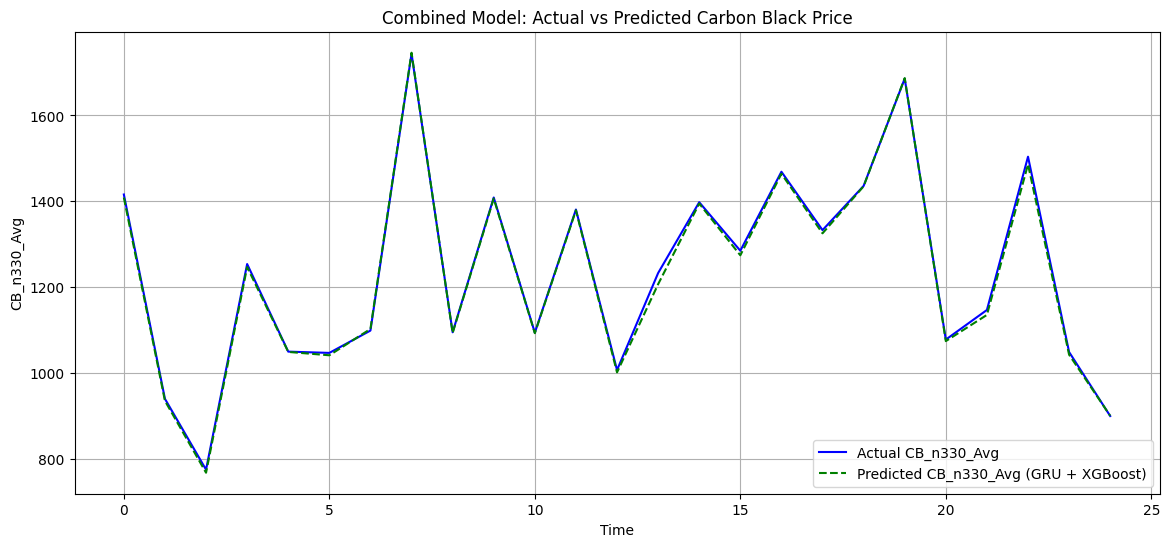

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from math import sqrt

# Load and preprocess the dataset
df = pd.read_csv('cb_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df.dropna(inplace=True)
df['Vol.'] = df['Vol.'].astype(str).str.replace(',', '').astype(float)
df.sort_values('Date', inplace=True)

# Define features and target
features = ['Open', 'High', 'Low', 'Vol.', 'Price', 'CB_n330_Low', 'CB_n330_High', 'BCO_Close', 'EMA_3']
target = 'CB_n330_Avg'

# Scale for GRU
scaler_gru = MinMaxScaler()
scaled_data = scaler_gru.fit_transform(df[features + [target]])
scaled_df = pd.DataFrame(scaled_data, columns=features + [target])

# Sequence creation for GRU
def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, :-1])
        y.append(data[i+time_steps, -1])
    return np.array(X), np.array(y)

time_steps = 12
X_gru, y_gru = create_sequences(scaled_df.values, time_steps)

# Train-test split for GRU
X_train_gru, X_test_gru, y_train_gru, y_test_gru = train_test_split(X_gru, y_gru, test_size=0.2, shuffle=False)

# Build and train GRU model
gru_model = Sequential([
    GRU(128, activation='tanh', return_sequences=True, input_shape=(X_train_gru.shape[1], X_train_gru.shape[2])),
    GRU(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
gru_model.fit(X_train_gru, y_train_gru, epochs=80, batch_size=16, validation_data=(X_test_gru, y_test_gru), verbose=1)

# Predict on all sequences to use as features for XGBoost
gru_preds_all = gru_model.predict(X_gru).flatten()

# Create new DataFrame with GRU predictions as feature
aligned_df = df.iloc[time_steps:].copy().reset_index(drop=True)  # Align with GRU output
aligned_df['GRU_Pred'] = scaler_gru.inverse_transform(np.concatenate([np.zeros((gru_preds_all.shape[0], len(features))), gru_preds_all.reshape(-1, 1)], axis=1))[:, -1]

# Prepare for XGBoost
X_xgb = aligned_df.drop(columns=['CB_n330_Avg', 'Date'])  # Drop target & date
y_xgb = aligned_df['CB_n330_Avg']

# Scale features
scaler_xgb_X = StandardScaler()
scaler_xgb_y = StandardScaler()

X_xgb_scaled = scaler_xgb_X.fit_transform(X_xgb)
y_xgb_scaled = scaler_xgb_y.fit_transform(y_xgb.values.reshape(-1, 1)).flatten()

# Train-test split for XGBoost
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb_scaled, y_xgb_scaled, test_size=0.2, random_state=42)

# Train XGBoost on enhanced features
xgb_model = XGBRegressor(
    objective="reg:squarederror", 
    n_estimators=150, 
    learning_rate=0.05, 
    max_depth=5, 
    subsample=0.8, 
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train_xgb, y_train_xgb)

# Predictions & Evaluation
y_pred_scaled = xgb_model.predict(X_test_xgb)
y_pred = scaler_xgb_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_rescaled = scaler_xgb_y.inverse_transform(y_test_xgb.reshape(-1, 1)).flatten()

rmse = sqrt(mean_squared_error(y_test_rescaled, y_pred))
accuracy = r2_score(y_test_rescaled, y_pred) * 100

print(f"Combined GRU + XGBoost RMSE: {rmse:.4f}")
print(f"Combined Accuracy: {accuracy:.2f}%")

# Plot results
plt.figure(figsize=(14, 6))
plt.plot(y_test_rescaled, label='Actual CB_n330_Avg', color='blue')
plt.plot(y_pred, label='Predicted CB_n330_Avg (GRU + XGBoost)', color='green', linestyle='--')
plt.title("Combined Model: Actual vs Predicted Carbon Black Price")
plt.xlabel("Time")
plt.ylabel("CB_n330_Avg")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from xgboost import XGBRegressor
from dateutil.relativedelta import relativedelta
from math import sqrt

# Load dataset
file_path = "cb_dataset.csv"
df = pd.read_csv(file_path)

# Preprocessing
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df.dropna(inplace=True)
df['Vol.'] = df['Vol.'].astype(str).str.replace(',', '').astype(float)
df.sort_values('Date', inplace=True)

# GRU SECTION 
gru_df = df.copy()
features = ['Open', 'High', 'Low', 'Vol.', 'Price', 'CB_n330_Low', 'CB_n330_High', 'BCO_Close', 'EMA_3']
target = 'CB_n330_Avg'

# Scaling
gru_scaler = MinMaxScaler()
scaled_data = gru_scaler.fit_transform(gru_df[features + [target]])
scaled_df = pd.DataFrame(scaled_data, columns=features + [target])

# Sequence generation
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :-1])
        y.append(data[i + time_steps, -1])
    return np.array(X), np.array(y)

time_steps = 12
X_gru, y_gru = create_sequences(scaled_df.values, time_steps)
X_train_gru, X_test_gru, y_train_gru, y_test_gru = train_test_split(X_gru, y_gru, test_size=0.2, random_state=42, shuffle=False)

# GRU Model
gru_model = Sequential([
    GRU(128, activation='tanh', input_shape=(X_train_gru.shape[1], X_train_gru.shape[2]), return_sequences=True),
    GRU(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train_gru, y_train_gru, epochs=80, batch_size=16, validation_data=(X_test_gru, y_test_gru), verbose=0)

# Reverse scaling
scaler_target = MinMaxScaler()
scaler_target.fit(df[[target]])
y_test_rescaled_gru = scaler_target.inverse_transform(y_test_gru.reshape(-1, 1))
predictions_gru = gru_model.predict(X_test_gru)
predictions_rescaled_gru = scaler_target.inverse_transform(predictions_gru)

# GRU future prediction (next 5 months)
future_months = 5
last_seq = X_test_gru[-1]
gru_future_predictions = []

for _ in range(future_months):
    next_pred = gru_model.predict(last_seq[np.newaxis, :, :])[0, 0]
    gru_future_predictions.append(next_pred)
    new_step = np.append(last_seq[1:], [np.append(last_seq[-1, :-1], next_pred)], axis=0)
    last_seq = new_step

gru_future_prices = scaler_target.inverse_transform(np.array(gru_future_predictions).reshape(-1, 1))
last_date = df['Date'].iloc[-1]
gru_future_dates = [last_date + relativedelta(months=i) for i in range(1, future_months + 1)]
gru_future_df = pd.DataFrame({'Date': gru_future_dates, 'GRU Predicted CB_n330_Avg': gru_future_prices.flatten()})

# XGBOOST SECTION 
xgb_df = df.copy()
xgb_df.set_index('Date', inplace=True)
X = xgb_df.drop(columns=['CB_n330_Avg'])
y = xgb_df['CB_n330_Avg']

# Scaling
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Train model
xgb_model = XGBRegressor(objective="reg:squarederror", n_estimators=150, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb_model.fit(X_train_xgb, y_train_xgb)

# Predict future using lag
def predict_future_xgb_lagged(model, last_data, steps, scaler_X, scaler_y):
    preds = []
    last_row = last_data[-1].copy()
    for _ in range(steps):
        pred_scaled = model.predict(last_row.reshape(1, -1))[0]
        pred = scaler_y.inverse_transform([[pred_scaled]])[0, 0]
        preds.append(pred)
        last_row = np.roll(last_row, -1)
        last_row[-1] = pred_scaled
    return preds

xgb_future_prices = predict_future_xgb_lagged(xgb_model, X_scaled, future_months, x_scaler, y_scaler)
xgb_future_dates = [xgb_df.index[-1] + relativedelta(months=i) for i in range(1, future_months + 1)]
xgb_future_df = pd.DataFrame({'Date': xgb_future_dates, 'XGBoost Predicted CB_n330_Avg': xgb_future_prices})

# COMBINED OUTPUT
combined_df = pd.merge(gru_future_df, xgb_future_df, on='Date')
print("Combined Future Predictions for Next 5 Months:")
print(combined_df)



1/1 [==============================] - 0s 17ms/step
Combined Future Predictions for Next 5 Months:
        Date  GRU Predicted CB_n330_Avg  XGBoost Predicted CB_n330_Avg
0 2023-09-01                1547.099976                    1801.866070
1 2023-10-01                1569.539795                    1684.474685
2 2023-11-01                1596.391357                    1492.777058
3 2023-12-01                1605.475098                    1757.760480
4 2024-01-01                1595.935303                    1731.962004


### GRU + XGBoost

Epoch 1/80
7/7 [==============================] - 3s 67ms/step - loss: 0.0482 - mae: 0.1729 - val_loss: 0.0120 - val_mae: 0.0798
Epoch 2/80
7/7 [==============================] - 0s 10ms/step - loss: 0.0147 - mae: 0.0967 - val_loss: 0.1089 - val_mae: 0.3108
Epoch 3/80
7/7 [==============================] - 0s 13ms/step - loss: 0.0118 - mae: 0.0922 - val_loss: 0.0213 - val_mae: 0.1263
Epoch 4/80
7/7 [==============================] - 0s 11ms/step - loss: 0.0086 - mae: 0.0717 - val_loss: 0.0505 - val_mae: 0.2049
Epoch 5/80
7/7 [==============================] - 0s 11ms/step - loss: 0.0074 - mae: 0.0706 - val_loss: 0.0375 - val_mae: 0.1745
Epoch 6/80
7/7 [==============================] - 0s 10ms/step - loss: 0.0056 - mae: 0.0588 - val_loss: 0.0291 - val_mae: 0.1490
Epoch 7/80
7/7 [==============================] - 0s 13ms/step - loss: 0.0047 - mae: 0.0534 - val_loss: 0.0347 - val_mae: 0.1634
Epoch 8/80
7/7 [==============================] - 0s 10ms/step - loss: 0.0041 - mae: 0.0490 - val

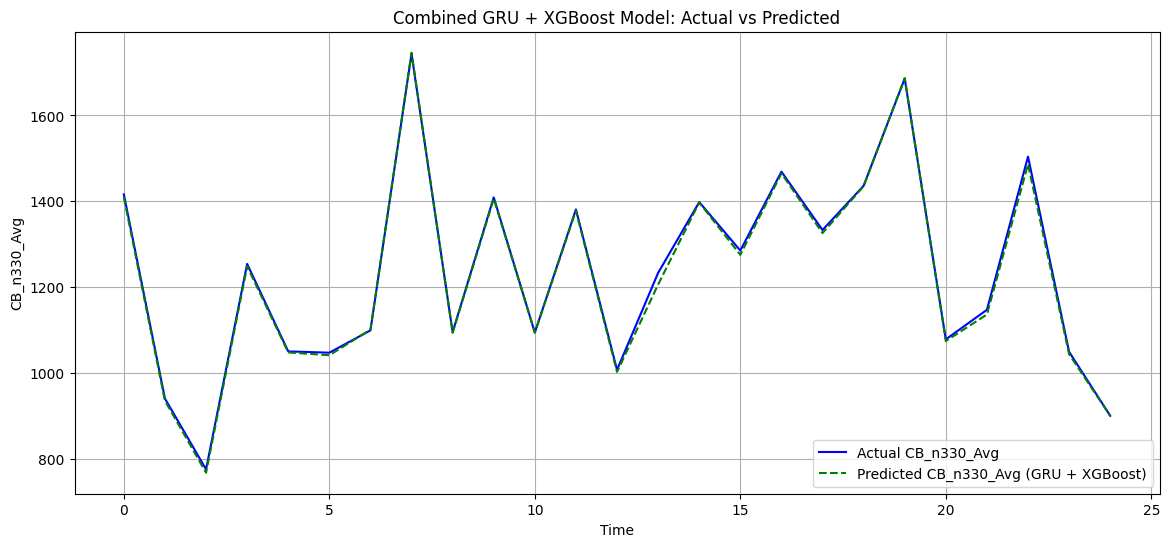

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBRegressor
from dateutil.relativedelta import relativedelta
from math import sqrt

# LOAD & PREPROCESS
file_path = "cb_dataset.csv"
df = pd.read_csv(file_path)

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df.dropna(inplace=True)
df['Vol.'] = df['Vol.'].astype(str).str.replace(',', '').astype(float)
df.sort_values('Date', inplace=True)

#  GRU MODEL
features = ['Open', 'High', 'Low', 'Vol.', 'Price', 'CB_n330_Low', 'CB_n330_High', 'BCO_Close', 'EMA_3']
target = 'CB_n330_Avg'

# Scaling
gru_scaler = MinMaxScaler()
scaled_data = gru_scaler.fit_transform(df[features + [target]])
scaled_df = pd.DataFrame(scaled_data, columns=features + [target])

# Create sequences
def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, :-1])
        y.append(data[i+time_steps, -1])
    return np.array(X), np.array(y)

time_steps = 12
X_gru, y_gru = create_sequences(scaled_df.values, time_steps)

# Train-test split
X_train_gru, X_test_gru, y_train_gru, y_test_gru = train_test_split(X_gru, y_gru, test_size=0.2, random_state=42, shuffle=False)

# Build GRU model
gru_model = Sequential([
    GRU(128, activation='tanh', return_sequences=True, input_shape=(X_train_gru.shape[1], X_train_gru.shape[2])),
    GRU(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train GRU model
gru_model.fit(X_train_gru, y_train_gru, epochs=80, batch_size=16, validation_data=(X_test_gru, y_test_gru), callbacks=[early_stop], verbose=1)

# Predict all sequences to use as feature
gru_preds_all = gru_model.predict(X_gru).flatten()

# Reverse scaling
scaler_target = MinMaxScaler()
scaler_target.fit(df[[target]])

# Align dataframe for XGBoost
aligned_df = df.iloc[time_steps:].copy().reset_index(drop=True)
aligned_df['GRU_Pred'] = gru_scaler.inverse_transform(
    np.concatenate([np.zeros((gru_preds_all.shape[0], len(features))), gru_preds_all.reshape(-1,1)], axis=1)
)[:, -1]

# XGBOOST MODEL
# Prepare features and target
X_xgb = aligned_df.drop(columns=['CB_n330_Avg', 'Date'])
y_xgb = aligned_df['CB_n330_Avg']

# Scaling
scaler_xgb_X = StandardScaler()
scaler_xgb_y = StandardScaler()

X_xgb_scaled = scaler_xgb_X.fit_transform(X_xgb)
y_xgb_scaled = scaler_xgb_y.fit_transform(y_xgb.values.reshape(-1, 1)).flatten()

# Train-test split
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb_scaled, y_xgb_scaled, test_size=0.2, random_state=42)

# Train XGBoost
xgb_model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=150,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train_xgb, y_train_xgb)

# Predictions & Evaluation
y_pred_scaled = xgb_model.predict(X_test_xgb)
y_pred = scaler_xgb_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_test_rescaled = scaler_xgb_y.inverse_transform(y_test_xgb.reshape(-1,1)).flatten()

rmse = sqrt(mean_squared_error(y_test_rescaled, y_pred))
accuracy = r2_score(y_test_rescaled, y_pred) * 100

print(f"Combined GRU + XGBoost RMSE: {rmse:.4f}")
print(f"Combined Accuracy: {accuracy:.2f}%")

# FUTURE PREDICTION 
future_months = 5

# For future prediction using lag
last_X = X_xgb_scaled[-1].reshape(1, -1)
future_preds = []

for _ in range(future_months):
    pred_scaled = xgb_model.predict(last_X)[0]
    pred_actual = scaler_xgb_y.inverse_transform([[pred_scaled]])[0, 0]
    future_preds.append(pred_actual)
    
    # Simulate next step (shift and add prediction)
    last_X = np.roll(last_X, -1)
    last_X[0, -1] = pred_scaled

# Generate future dates
last_known_date = aligned_df['Date'].iloc[-1]
future_dates = [last_known_date + relativedelta(months=i) for i in range(1, future_months+1)]

future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted CB_n330_Avg (GRU + XGBoost)': future_preds
})

print("\nFuture 5-Month Carbon Black Price Predictions:")
print(future_df)

# PLOT 
plt.figure(figsize=(14, 6))
plt.plot(y_test_rescaled, label='Actual CB_n330_Avg', color='blue')
plt.plot(y_pred, label='Predicted CB_n330_Avg (GRU + XGBoost)', color='green', linestyle='--')
plt.title("Combined GRU + XGBoost Model: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("CB_n330_Avg")
plt.legend()
plt.grid()
plt.show()


## Finalised Hybrid Models 

### LSTM + XGBoost 

1/1 [==============================] - 0s 111ms/step
Hybrid Model Evaluation (CB_n330_Avg):
RMSE: 172.5248
MSE: 29764.8182
MAE: 143.2363
R2 Score: 0.1038
Accuracy: 91.42%


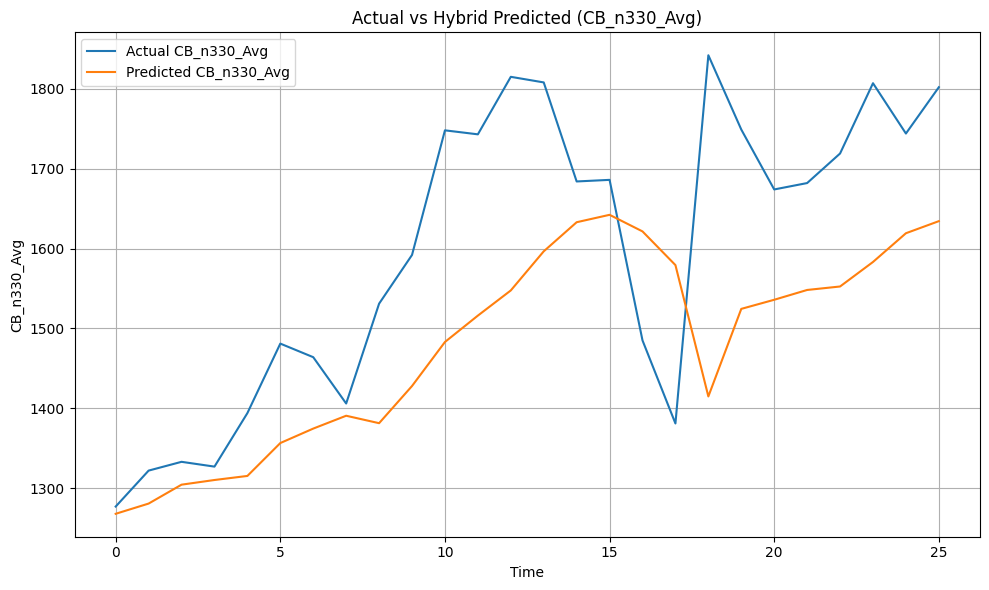


Future 4 Months Hybrid CB_n330_Avg Predictions (Starting from Sept 1, 2023):
2023-09-01: 1636.95
2023-10-01: 1609.52
2023-11-01: 1586.75
2023-12-01: 1559.43


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

import xgboost as xgb

#  Load Dataset 
df = pd.read_csv('cb_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

#  Prepare Data 
data = df[['CB_n330_Avg']].dropna()

#  Feature Scaling 
scaler_y = MinMaxScaler()
data_scaled = scaler_y.fit_transform(data)

#  Create Sequences 
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(data_scaled, seq_length)

#  Train-Test Split 
train_size = int(len(X) * 0.8)
X_train_lstm, X_test_lstm = X[:train_size], X[train_size:]
y_train_lstm, y_test_lstm = y[:train_size], y[train_size:]

#  LSTM Model 
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_lstm, y_train_lstm,
                    epochs=100,
                    batch_size=16,
                    validation_data=(X_test_lstm, y_test_lstm),
                    callbacks=[early_stop],
                    verbose=0)

#  LSTM Predictions 
predictions = model.predict(X_test_lstm)
predictions_rescaled = scaler_y.inverse_transform(predictions).flatten()
y_test_rescaled = scaler_y.inverse_transform(y_test_lstm).flatten()

#  XGBoost Data Preparation 
X_xgb = []
for i in range(len(data_scaled) - seq_length):
    X_xgb.append(data_scaled[i:i + seq_length].flatten())
X_xgb = np.array(X_xgb)

X_train_xgb = X_xgb[:train_size]
X_test_xgb = X_xgb[train_size:]
y_train_xgb = y[:train_size].flatten()
y_test_xgb = y[train_size:].flatten()

#  XGBoost Model 
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train_xgb, y_train_xgb)

#  XGBoost Predictions 
y_pred_xgb = xgb_model.predict(X_test_xgb)
y_pred_xgb_rescaled = scaler_y.inverse_transform(y_pred_xgb.reshape(-1, 1)).flatten()

#  Hybrid Model 
min_len = min(len(predictions_rescaled), len(y_pred_xgb_rescaled))
predictions_lstm = predictions_rescaled[:min_len]
y_pred_xgb_trimmed = y_pred_xgb_rescaled[:min_len]
y_test_combined = y_test_rescaled[:min_len].flatten()

hybrid_test_pred = (predictions_lstm + y_pred_xgb_trimmed) / 2

#  Evaluation 
hybrid_rmse = sqrt(mean_squared_error(y_test_combined, hybrid_test_pred))
hybrid_mse = mean_squared_error(y_test_combined, hybrid_test_pred)
hybrid_mae = mean_absolute_error(y_test_combined, hybrid_test_pred)
hybrid_r2 = r2_score(y_test_combined, hybrid_test_pred)
hybrid_accuracy = 100 - np.mean(np.abs((y_test_combined - hybrid_test_pred) / y_test_combined)) * 100

print(f'Hybrid Model Evaluation (CB_n330_Avg):')
print(f'RMSE: {hybrid_rmse:.4f}')
print(f'MSE: {hybrid_mse:.4f}')
print(f'MAE: {hybrid_mae:.4f}')
print(f'R2 Score: {hybrid_r2:.4f}')
print(f'Accuracy: {hybrid_accuracy:.2f}%')

#  Plot Actual vs Predicted 
plt.figure(figsize=(10, 6))
plt.plot(y_test_combined, label='Actual CB_n330_Avg')
plt.plot(hybrid_test_pred, label='Predicted CB_n330_Avg')
plt.title('Actual vs Hybrid Predicted (CB_n330_Avg)')
plt.xlabel('Time')
plt.ylabel('CB_n330_Avg')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  Future Prediction (Next 4 Months in CB_n330_Avg) 
last_sequence = data_scaled[-seq_length:]
future_predictions = []

# Start date for future predictions
start_date = pd.to_datetime('2023-09-01')

# Start with the first prediction for 2023-09-01
lstm_input = last_sequence.reshape(1, seq_length, 1)
lstm_pred = model.predict(lstm_input, verbose=0)[0][0]

xgb_input = last_sequence.flatten().reshape(1, -1)
xgb_pred = xgb_model.predict(xgb_input)[0]

hybrid_pred = (lstm_pred + xgb_pred) / 2
future_predictions.append(hybrid_pred)

# Append and slide for future predictions
last_sequence = np.append(last_sequence, [[hybrid_pred]], axis=0)[1:]

# For the next 3 months
for i in range(1, 4):
    lstm_input = last_sequence.reshape(1, seq_length, 1)
    lstm_pred = model.predict(lstm_input, verbose=0)[0][0]

    xgb_input = last_sequence.flatten().reshape(1, -1)
    xgb_pred = xgb_model.predict(xgb_input)[0]

    hybrid_pred = (lstm_pred + xgb_pred) / 2
    future_predictions.append(hybrid_pred)

    # Append and slide
    last_sequence = np.append(last_sequence, [[hybrid_pred]], axis=0)[1:]

# Inverse transform CB_n330_Avg
future_predictions_rescaled = scaler_y.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

#  Print Future CB_n330_Avg Predictions 
print("\nFuture 4 Months Hybrid CB_n330_Avg Predictions (Starting from Sept 1, 2023):")
for i, val in enumerate(future_predictions_rescaled):
    future_date = start_date + pd.DateOffset(months=i)  # Increment by 1 month
    print(f"{future_date.strftime('%Y-%m-%d')}: {val:.2f}")


### GRU + XGBoost

1/1 [==============================] - 0s 111ms/step
Hybrid GRU + XGBoost Model Evaluation (CB_n330_Avg):
RMSE: 171.0645
MSE: 29263.0470
MAE: 140.2097
R2 Score: 0.1190
Accuracy: 91.64%


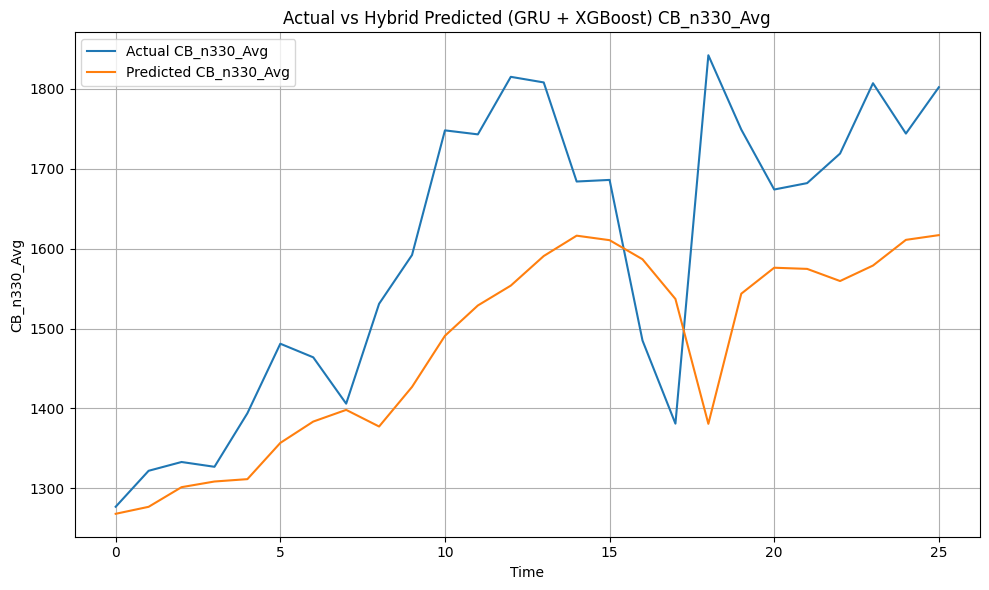


Future 4 Months Hybrid GRU + XGBoost CB_n330_Avg Predictions (Starting from Sept 1, 2023):
2023-09-01: 1615.25
2023-10-01: 1572.99
2023-11-01: 1549.23
2023-12-01: 1524.61


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

import xgboost as xgb

#  Load Dataset 
df = pd.read_csv('cb_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

#  Prepare Data 
data = df[['CB_n330_Avg']].dropna()

# Feature Scaling 
scaler_y = MinMaxScaler()
data_scaled = scaler_y.fit_transform(data)

#  Create Sequences 
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(data_scaled, seq_length)

#  Train-Test Split 
train_size = int(len(X) * 0.8)
X_train_lstm, X_test_lstm = X[:train_size], X[train_size:]
y_train_lstm, y_test_lstm = y[:train_size], y[train_size:]

#  GRU Model 
gru_model = Sequential()
gru_model.add(GRU(64, activation='relu', input_shape=(seq_length, 1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mse')

# EarlyStopping callback to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the GRU model
history_gru = gru_model.fit(X_train_lstm, y_train_lstm,
                            epochs=100,
                            batch_size=16,
                            validation_data=(X_test_lstm, y_test_lstm),
                            callbacks=[early_stop],
                            verbose=0)

# GRU Predictions 
gru_predictions = gru_model.predict(X_test_lstm)
gru_predictions_rescaled = scaler_y.inverse_transform(gru_predictions).flatten()
y_test_rescaled = scaler_y.inverse_transform(y_test_lstm).flatten()

#  XGBoost Data Preparation 
X_xgb = []
for i in range(len(data_scaled) - seq_length):
    X_xgb.append(data_scaled[i:i + seq_length].flatten())
X_xgb = np.array(X_xgb)

X_train_xgb = X_xgb[:train_size]
X_test_xgb = X_xgb[train_size:]
y_train_xgb = y[:train_size].flatten()
y_test_xgb = y[train_size:].flatten()

#  XGBoost Model 
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train_xgb, y_train_xgb)

# XGBoost Predictions 
y_pred_xgb = xgb_model.predict(X_test_xgb)
y_pred_xgb_rescaled = scaler_y.inverse_transform(y_pred_xgb.reshape(-1, 1)).flatten()

# Hybrid Model GRU + XGBoost 
min_len = min(len(gru_predictions_rescaled), len(y_pred_xgb_rescaled))
gru_predictions_lstm = gru_predictions_rescaled[:min_len]
y_pred_xgb_trimmed = y_pred_xgb_rescaled[:min_len]
y_test_combined = y_test_rescaled[:min_len].flatten()

hybrid_test_pred_gru = (gru_predictions_lstm + y_pred_xgb_trimmed) / 2

# Evaluation 
hybrid_rmse_gru = sqrt(mean_squared_error(y_test_combined, hybrid_test_pred_gru))
hybrid_mse_gru = mean_squared_error(y_test_combined, hybrid_test_pred_gru)
hybrid_mae_gru = mean_absolute_error(y_test_combined, hybrid_test_pred_gru)
hybrid_r2_gru = r2_score(y_test_combined, hybrid_test_pred_gru)
hybrid_accuracy_gru = 100 - np.mean(np.abs((y_test_combined - hybrid_test_pred_gru) / y_test_combined)) * 100

print(f'Hybrid GRU + XGBoost Model Evaluation (CB_n330_Avg):')
print(f'RMSE: {hybrid_rmse_gru:.4f}')
print(f'MSE: {hybrid_mse_gru:.4f}')
print(f'MAE: {hybrid_mae_gru:.4f}')
print(f'R2 Score: {hybrid_r2_gru:.4f}')
print(f'Accuracy: {hybrid_accuracy_gru:.2f}%')

#  Plot Actual vs Predicted for GRU + XGBoost Hybrid 
plt.figure(figsize=(10, 6))
plt.plot(y_test_combined, label='Actual CB_n330_Avg')
plt.plot(hybrid_test_pred_gru, label='Predicted CB_n330_Avg')
plt.title('Actual vs Hybrid Predicted (GRU + XGBoost) CB_n330_Avg')
plt.xlabel('Time')
plt.ylabel('CB_n330_Avg')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Future Prediction (Next 4 Months in CB_n330_Avg) 
last_sequence = data_scaled[-seq_length:]
future_predictions_gru = []

# Start date for future predictions
start_date = pd.to_datetime('2023-09-01')

# Start with the first prediction for 2023-09-01
gru_input = last_sequence.reshape(1, seq_length, 1)
gru_pred = gru_model.predict(gru_input, verbose=0)[0][0]

xgb_input = last_sequence.flatten().reshape(1, -1)
xgb_pred = xgb_model.predict(xgb_input)[0]

hybrid_pred_gru = (gru_pred + xgb_pred) / 2
future_predictions_gru.append(hybrid_pred_gru)

# Append and slide for future predictions
last_sequence = np.append(last_sequence, [[hybrid_pred_gru]], axis=0)[1:]

# For the next 3 months
for i in range(1, 4):
    gru_input = last_sequence.reshape(1, seq_length, 1)
    gru_pred = gru_model.predict(gru_input, verbose=0)[0][0]

    xgb_input = last_sequence.flatten().reshape(1, -1)
    xgb_pred = xgb_model.predict(xgb_input)[0]

    hybrid_pred_gru = (gru_pred + xgb_pred) / 2
    future_predictions_gru.append(hybrid_pred_gru)

    # Append and slide
    last_sequence = np.append(last_sequence, [[hybrid_pred_gru]], axis=0)[1:]

# Inverse transform CB_n330_Avg
future_predictions_rescaled_gru = scaler_y.inverse_transform(np.array(future_predictions_gru).reshape(-1, 1)).flatten()

# Print Future CB_n330_Avg Predictions for GRU + XGBoost
print("\nFuture 4 Months Hybrid GRU + XGBoost CB_n330_Avg Predictions (Starting from Sept 1, 2023):")
for i, val in enumerate(future_predictions_rescaled_gru):
    future_date = start_date + pd.DateOffset(months=i)  # Increment by 1 month
    print(f"{future_date.strftime('%Y-%m-%d')}: {val:.2f}")
